# <center>Project: Wraggle and Analyze Data</center>
<center>Udacity Data Analyst Nanodegree Project</center>

## Introduction
This project looks into Twitter's available @WeRateDogs tweet data and creates a trustworthy analysis and visualization report. This @WeRateDogs Twitter account rates people's dogs with humorous comments.

## Goal
The goal of this project is to walk-through the complete process of data analysis, from gathering data to reporting.

    1: Gathering data
    2: Assessing data
    3: Cleaning data
    4: Storing data
    5: Analyzing, and visualizing data
    6: Reporting
    
The focus of this project is more on data wrangling process which involves the first four steps: gathering, assessing, cleaning, restructuring and enriching the raw available data into a more usable format.

## Data Sources
@WeRateDogs tweet data are available from three difference sources and in different formats:

* `twitter_archive_enhanced.csv`
    * This Twitter archives file contains 5000+ of tweet archive of the Twitter user @WeRateDogs
    * It is available to download in the project resources
    * The data is in CSV format
* `image_predictions.tsv` 
    * This image prediction file contains what breed of dog is present in each tweet according to a neural network
    * It is hosted on Udacity's sever and need to be fetched programatically via Python requests package
    * The data is in tab seperated format
* `tweet-json.txt`
    * This tweet json file contain a lot of tweet information including retreet counts and favorite counts
    * This data is pulled directly from Twitter using Twitter API via Python Tweepy package and then is written in a text file
    * It is a text file in json format

## Required Packages

In [898]:
import os
import json
import tweepy
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from json import JSONDecodeError
from matplotlib import rcParams

%matplotlib inline

## Gathering, Assessing, and Cleaning Data

In [934]:
DATA_PATH = 'data'
IMG_PATH = 'imgs'

### <span style="color:red">File: twitter_archive_enhanced.csv</span>

`twitter-archive-enhanced.csv` is downloaded from Udacity's project resources. It's in CSV format. A quick initial assessment was done by Google Spreadsheet. The file is then read into Pandas dataframe for further assessment and cleaning.

#### Data Quality Issues:
1. Null value in columns:
    * in_reply_to_status_id
    * in_reply_to_user_id
    * retweeted_status_id
    * retweeted_status_user_id
    * retweeted_status_timestamp
2. None value in Columns:
    * doggo
    * floofer
    * pupper
    * puppo 
3. The 'None' value in `name` column should be ok in this case. I think It's normal for people not to share too much information.
4. Inconsistent rating system 

#### Data Tidiness Issues:
1. The last four columns can be combined into one (e.g. ages or types)

In [900]:
def get_twitter_archive():
    fname = 'twitter-archive-enhanced.csv'
    df = pd.read_csv(os.path.join(DATA_PATH, fname), parse_dates=[3], index_col=[0])
    return df

In [901]:
df = get_twitter_archive()

#### Investigate The Rating System
* rating_numerator range from 0 to 1776
* rating_denominator range from 0 to 170

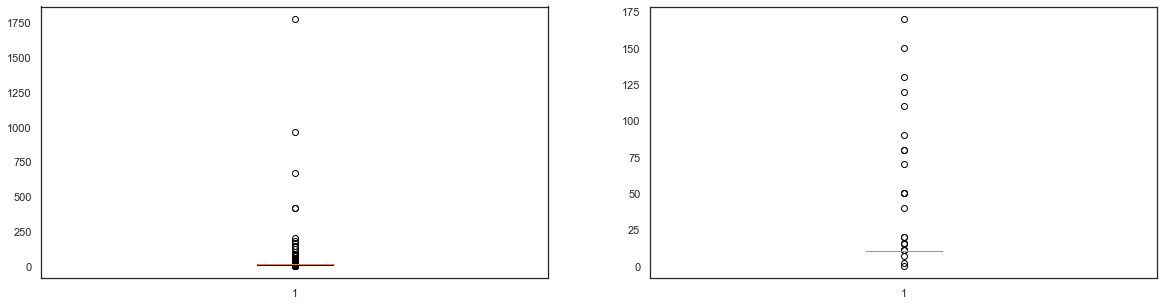

In [902]:
plt.figure(figsize = [20, 5])

# Histogram on the left, bin edges on integers
plt.subplot(1, 2, 1)
bin_edges = np.arange(2, 12+1.1, 1) # note `+1.1`, see below
plt.boxplot(df.rating_numerator);

# Histogram on the right, bin edges between integers
plt.subplot(1, 2, 2)
plt.boxplot(df.rating_denominator);

In [903]:
df.query('rating_numerator==0 or rating_numerator==1776')[['rating_numerator', 'rating_denominator']]

,rating_numerator,rating_denominator
tweet_id,,
835152434251116546,0,10
749981277374128128,1776,10
746906459439529985,0,10


In [904]:
df.query('rating_denominator==0 or rating_denominator==170')[['rating_numerator', 'rating_denominator']]

,rating_numerator,rating_denominator
tweet_id,,
835246439529840640,960,0
731156023742988288,204,170


In [905]:
df.query('rating_denominator<10 or rating_numerator>200')[['rating_numerator', 'rating_denominator']]

,rating_numerator,rating_denominator
tweet_id,,
855862651834028034,420,10
855860136149123072,666,10
835246439529840640,960,0
810984652412424192,24,7
749981277374128128,1776,10
731156023742988288,204,170
670842764863651840,420,10
666287406224695296,1,2


In [906]:
def clean_twitter_archive():
    df = get_twitter_archive()
    
    # Extract only relavant columns
    df = df[['rating_numerator', 'rating_denominator', 'name']]
    
    # Check for any Nan value in each column
    for label in df.columns.tolist():
        assert df[df[label].isnull() == True].shape != 0
        
    # Replace None with no-name under column 'name'
    df['name'] = df['name'].str.replace('None', 'no-name')
    
    # Remove outliners in rating_denominator and rating_numerator
    outliners = df.query('rating_denominator<10 or rating_numerator>200')
    df = df.drop(outliners.index)
    
    assert df_archive.query('rating_denominator<10 or rating_numerator>200').shape[0] == 0
        
    # Add a column for rating
    df['rating'] = df.rating_numerator / df.rating_denominator
    
    # Remove rows with zero rating
    zero_ratings = df.query('rating==0')
    df = df.drop(zero_ratings.index)
    
    assert df.query('rating==0').shape[0] == 0
    
    return df

In [907]:
df_archive = clean_twitter_archive()
df_archive.sample(2)

,rating_numerator,rating_denominator,name,rating
tweet_id,,,,
763956972077010945,12,10,no-name,1.2
812503143955202048,13,10,no-name,1.3


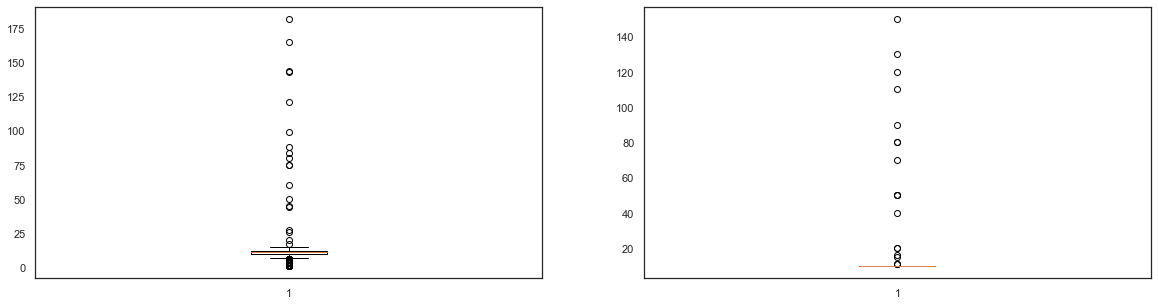

In [908]:
plt.figure(figsize = [20, 5])

# Histogram on the left, bin edges on integers
plt.subplot(1, 2, 1)
bin_edges = np.arange(2, 12+1.1, 1) # note `+1.1`, see below
plt.boxplot(df_archive.rating_numerator);

# Histogram on the right, bin edges between integers
plt.subplot(1, 2, 2)
plt.boxplot(df_archive.rating_denominator);

### <span style="color:red">File: image_predictions.tsv</span>

`image_predictions.tsv` is fetched from Udacity server via Python Requests package. It's in TSV format. A quick initial assessment was done by Google Spreadsheet. The file is then read into Pandas dataframe for further assessment and cleaning.

#### Data Quality Issues:
* Column names are misleading (e.g. p1_dog has True and False value)
* Non-dog-breed names in the `p1` column
    * 'shopping_cart', 'hen', 'desktop_computer', 'guinea_pig', 'llama', 'seat_belt', etc
* Non-dog-breed names in the `p2` column
    * 'punching_bag', 'comic_book', 'sunglass', 'can_opener', 'cup', 'rule', 'soccer_ball', 'bucket', etc.
* Non-dog-breed names in the `p3`, column
    * 'paintbrush', 'maze', 'hatchet', 'chain', 'jigsaw_puzzle', 'switch', plastic_bag', 'swimming_trunks', 'prairie_chicken', 'red_wolf', etc.
    
#### Data Tidiness Issues:
* Data in this file should be combine with the 'twitter-archive-enhanced.csv' since they are additional information to the same tweets
    
**To clean the non-dog-breed names in 'p1', 'p2', 'p3' names, a complete list of dog breeds data need to be gathered from somewhere in order to validate whether the names are a valid dog-breed. However, for my analysis to find the top 5 most retweet and 5 most favorite breed/dog on Twitter @WeRateDogs. This step is not be necessarity for this analysis.**

In [909]:
def get_image_predictions():
    """
    Get image_preditions.tsv from Udacity's server and save to local drive.
    """
    url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
    fname = 'image_predictions.tsv'
    
    if not os.path.exists(os.path.join(DATA_PATH, fname)):
        response = requests.get(url)
        with open(fname, mode='wb') as file:
             file.write(response.content)
    
    # Verified that there is not duplicate tweet_id before setting tweet_id column as index
    df = pd.read_csv(fname, sep='\t', index_col=0)
    return df

In [910]:
def clean_image_predictions():
    """
    Clean up some data quality issues and extract only true prediction data
    """
    df = get_image_predictions()
    
    # Observed and verified the confidence in 'p1_conf' is always greater then p2_conf or p3_conf
    assert df[df['p2_conf'] < df['p3_conf']].shape[0] == 0
    
    # Rename column names to be more meaningfull
    df.rename(columns={'p1_dog': 'p1_outcome', 'p2_dog': 'p2_outcome', 'p3_dog': 'p3_outcome'}, inplace=True)
    df.rename(columns={'p1': 'p1_dog', 'p2': 'p2_dog', 'p3': 'p3_dog'}, inplace=True)
    
    # Select only rows with true predictions
    false_outcomes = df.query('p1_outcome==False and p2_outcome==False and p3_outcome==False')
    df.drop(false_outcomes.index, inplace=True)
    
    # Extract rows with true predictions and with the highest confident
    df_preds_1 = df.query('p1_outcome==True')
    df_preds_2 = df.query('p1_outcome==False and p2_outcome==True')
    df_preds_3 = df.query('p1_outcome==False and p2_outcome==False and p2_outcome==True')  # Zero row for this query
    
    df_preds_1 = df_preds_1[['p1_dog', 'p1_conf', 'p1_outcome']]
    df_preds_1.columns = ['breed', 'conf', 'outcome']
    
    df_preds_2 = df_preds_2[['p2_dog', 'p2_conf', 'p2_outcome']]
    df_preds_2.columns = ['breed', 'conf', 'outcome']
    
    df_preds = pd.concat([df_preds_1, df_preds_2])
    
    return df_preds

In [911]:
df_images = clean_image_predictions()
df_images.sample(2)

,breed,conf,outcome
tweet_id,,,
735635087207878657,pug,0.891871,True
669359674819481600,Labrador_retriever,0.367818,True


### <span style="color:red">File: tweet_json.txt</span>

`tweet_json.txt` is a text file contains tweets information that directly pulled from Twitter using Python tweepy package. Each line is a json dictionary for each tweet. After all the tweet information is gathered and written into a text file, it is then read into a Pandas DataFrame line-by-line. After reviewing a couple rows of data, only three pieces of information (id, retweet_count, and favorite_count) are relevant to this analysis.

#### Assessing:
The assessing of this data is done using Google spreadsheet looking at the raw json format. There are a lot of information, but I don't need all of those information. Instead of creating a Pandas DataFrame with all the unnecessarity inforation and cleaning it after, I took the route to just extract the relavant information (the retweet and favorite counts). This would save time and space when processing the data.

#### Data Quality Issues:
* Due to the data is directly pulled from Twitter and I only need to pull two relavant data (retweet and favorite count), I have confident those are accurate. Not much cleaning is needed.

#### Data Tidiness Issues:
* The retweet counts and favorite counts should also be combine with the other data. They are just additional information of the tweets.

In [912]:
# Script to pull tweets from Twitter using tweepy package

import os
import time
import json
import tweepy
import webbrowser

import pandas as pd

CONSUMER_KEY = os.environ.get('TWITTER_API_KEY')
CONSUMER_SECRET = os.environ.get('TWITTER_SECRET')
DATA_PATH = 'data'


def authorize_access():
  """ Return tweepy.api after authorize access with Twitter. """
  callback_uri = 'oob'
  auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET, callback_uri)
  redirect_url = auth.get_authorization_url()
  print(redirect_url)

  auth_pin = input('What is the pin value? ')
  access_token, access_token_secret = auth.get_access_token(auth_pin)
  auth.set_access_token(access_token, access_token_secret)
  api = tweepy.API(auth)
  return api


def write_to_files(contents, errors):
  """ Write tweet information and errors into text files. """
  w_file = os.path.join(DATA_PATH, 'tweet-json.txt')
  e_file = os.path.join(DATA_PATH, 'tweet-errors.txt')

  if contents: 
    with open(w_file, encoding='utf-8', mode='w') as f:
      print(contents)
      f.write('\n'.join(contents))

  if errors:
    with open(e_file, encoding='utf-8', mode='w') as f:
      f.write('\n'.join(errors))


def get_tweet_ids():
  """ Get tweet ids from twitter-archive-enhanced.csv file. """
  fname = 'twitter-archive-enhanced.csv'
  f = os.path.join(DATA_PATH, fname)

  if os.path.exists(f):
    df = pd.read_csv(f)
  else:
    print(f'file ({f}) does not exist.')

  return df.tweet_id.to_list()


def in_three():
  """ Divide all tweet ids into three parts. """
  parts = []
  tweet_ids = get_tweet_ids()
  in_three = len(tweet_ids)//3

  parts.append(tweet_ids[0:in_three])
  parts.append(tweet_ids[in_three:in_three*2])
  parts.append(tweet_ids[in_three*2:])

  return parts


def get_twitter_tweets():
  """ Get tweet information from Twitter in three intervals due to Twitter's rate limit. """
  contents = []
  errors = []

  api = authorize_access()
  three_parts = in_three()

  for tweet_ids in three_parts:
    for tweet_id in tweet_ids:
      try:
        tweet = api.get_status(tweet_id, tweet_mode='extended')
      except tweepy.errors.NotFound as e:
        errors.append(f'NOT FOUND: {e}')
      except tweepy.errors.Forbidden as e:
        errors.append(f'FORBIDDEN: {tweet_id}')
      except:
        errors.append(f'ERROR: {tweet_id}')

      info = tweet.__dict__.get('_json')
      contents.append(json.dumps(info))
      print(tweet.id, tweet.retweet_count, tweet.favorite_count)

    time.sleep(915)

  write_to_files(contents, errors)

In [913]:
def parse_tweet_json_to_df():
    """ Retrieve tweet id, retweet_count, and favorite_count from `tweet_json.txt` file. """
    r_fname = 'tweet-json.txt'
    w_fname = 'tweet-json.csv'
    
    df = pd.DataFrame(columns=['tweet_id', 'retweet_cnt', 'favorite_cnt'])

    # Check to see if the json file exists
    if not os.path.exists(os.path.join(DATA_PATH, r_fname)):
        print('File does not exist.')
        return
    
    # Get only interested data
    with open(os.path.join(DATA_PATH, r_fname), 'r') as f:
        while True:
            row = f.readline()
            
            if not row: break

            try:
                row_dict = json.loads(row)
            except JSONDecodeError as e:
                print(f'<Decoding Error> : {e}')
                            
            id_ = row_dict.get('id')
            retweet_cnt = row_dict.get('retweet_count')
            favorite_cnt = row_dict.get('favorite_count')
            
            df.loc[len(df)] = [id_, retweet_cnt, favorite_cnt]    
            
    df.to_csv(os.path.join(DATA_PATH, w_fname))
    return df

In [914]:
df_retweet = parse_tweet_json_to_df()
df_retweet.shape, df_retweet.head(3)

((2356, 3),
              tweet_id  retweet_cnt  favorite_cnt
 0  892420643555336193         6983         33732
 1  892177421306343426         5285         29267
 2  891815181378084864         3469         21998)

## Merge Three Cleaned Dataset Together

In [915]:
MERGED_FILE = 'tweet_merged.csv'

def merge_three_datasets(df_archive, df_images, df_retweet):
    df_merged = df_archive.merge(df_images, on='tweet_id')
    df_merged = df_merged.merge(df_retweet, on='tweet_id')
    
    # Check for any NaN value in the merged dataset
    for col in df_merged.columns:
        assert df_merged[col].shape[0] == df_merged.shape[0]
        
    # Set tweet_id as index
    df_merged = df_merged.set_index('tweet_id')
        
    # write to csv
    df_merged.to_csv(os.path.join(DATA_PATH, MERGED_FILE))
    
    return df_merged

In [916]:
df_merged = merge_three_datasets(df_archive, df_images, df_retweet)
df_merged.sample(3)

,rating_numerator,rating_denominator,name,rating,breed,conf,outcome,retweet_cnt,favorite_cnt
tweet_id,,,,,,,,,
671122204919246848,4,10,no-name,0.4,Chihuahua,0.101228,True,2183,3082
667728196545200128,11,10,Olive,1.1,kuvasz,0.360159,True,126,325
817423860136083457,13,10,Ken,1.3,Samoyed,0.201358,True,13562,31781


## Analyzing and Visualization

### Q1: What are The Top Five Most Tweeted Breeds?

In [938]:
TOP_NUMS = 5
BREEDS = 'Breeds'
BASE_COLOR = sns.color_palette()[0]
FIG_SIZE = (12,5)

MERGED_FILE = os.path.join(DATA_PATH, 'tweet_merged.csv')

In [940]:
def top_tweeted_breed():
    df = pd.read_csv(MERGED_FILE)
    top_breed = df['breed'].value_counts(sort=True)[:TOP_NUMS]
    
    base_color = BASE_COLOR
    order = top_breed.index
    ax = sns.countplot(data=df, y='breed', color=base_color, order=order);

    ax.set(xlabel='Tweet Counts',
           ylabel=BREEDS,
           title=f'Top {TOP_NUMS} Most Tweeted Breeds');

    # Calculate and label percentage
    for i in range(top_breed.shape[0]):
        count = top_breed[i]
        pct = f'{100*count/n_rows:0.1f}%'
        plt.text(count+1, i, pct, va='center')

    rcParams['figure.figsize'] = FIG_SIZE
    
    plt.savefig(os.path.join(IMG_PATH, 'top_tweeted_breed'))

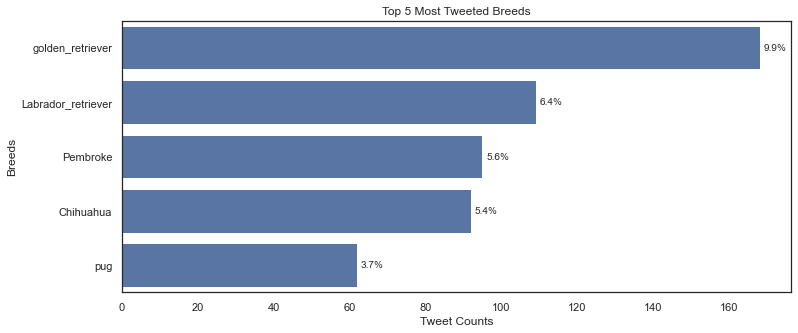

In [941]:
top_tweeted_breed()

### Q2: What are the Top Five Most Retweeted Dogs?

In [942]:
def top_retweeted_dogs():
    df = pd.read_csv(MERGED_FILE)
    top_retweets = df.sort_values(by='retweet_cnt', ascending=False)[:TOP_NUMS]
    
    color = BASE_COLOR
    ax = sns.barplot(data=top_retweets, x='retweet_cnt', y='breed', color=color)
    ax.set(xlabel='Retweet Counts',
           ylabel=BREEDS,
           title=f'Top {TOP_NUMS} Re-tweeted Dogs')

    for i,v in enumerate(top_retweets.index.tolist()):
        count = top_retweets.iloc[i:].retweet_cnt.values[0]
        name = top_retweets.iloc[i:].name.values[0]
        txt = f'{name} / {count}'
        plt.text(count+500, i, txt)

    rcParams['figure.figsize'] = FIG_SIZE
    
    plt.savefig(os.path.join(IMG_PATH, 'top_retweeted_dogs'))

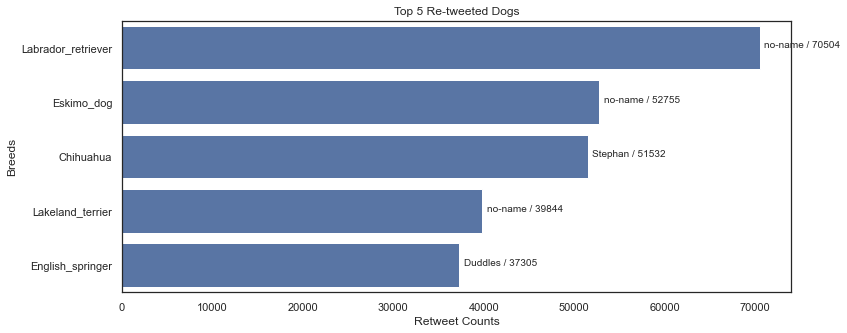

In [943]:
top_retweeted_dogs()

### Q3: What are the Top Five Most Favorite Dogs?

In [944]:
def top_favorite_dogs():
    df = pd.read_csv(MERGED_FILE)
    top_favorites = df.sort_values(by='favorite_cnt', ascending=False)[:TOP_NUMS]
    
    color = BASE_COLOR
    ax = sns.barplot(data=top_favorites, x='favorite_cnt', y='breed', color=color)
    ax.set(xlabel='Favorite Counts',
           ylabel=BREEDS,
           title=f'Top {TOP_NUMS} Most Favorite Dogs')

    for i,v in enumerate(top_favorites.index.tolist()):
        count = top_favorites.iloc[i:].favorite_cnt.values[0]
        name = top_favorites.iloc[i:].name.values[0]
        txt = f'{name} / {count})'
        plt.text(count+500, i, txt)

    rcParams['figure.figsize'] = FIG_SIZE
    
    plt.savefig(os.path.join(IMG_PATH, 'top_favorite_dogs'))

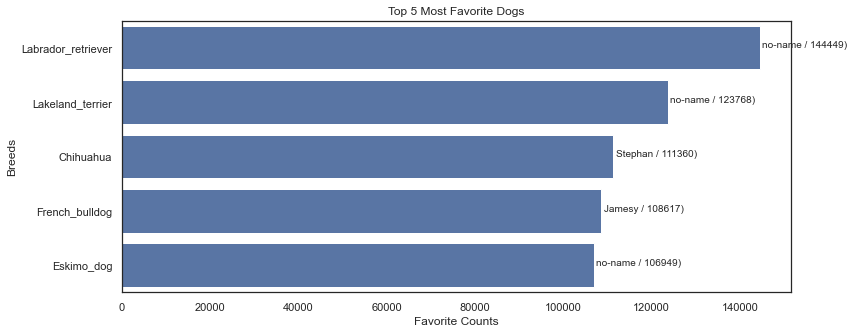

In [945]:
top_favorite_dogs()

### Q4: How is the rating correlate to retweet count and favorite count?

In [946]:
def rating_retweet_favorite():
    df = pd.read_csv(MERGED_FILE)
    
    # Remove few outliner where rating is greater than 2
    outliners = df.query('rating > 2')
    df = df.drop(outliners.index)
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=FIG_SIZE)
    ax1.scatter(df.rating, df.retweet_cnt);
    ax1.set(title="Rating vs Retweet Counts", 
            xlabel='Rating',
            ylabel='Retweet Counts')

    ax2.scatter(df.rating, df.favorite_cnt);
    ax2.set(title="Rating vs Favorite Counts", 
            xlabel='Rating',
            ylabel='Favorite Counts')
    
    plt.savefig(os.path.join(IMG_PATH, 'rating_retweet_favorite'))

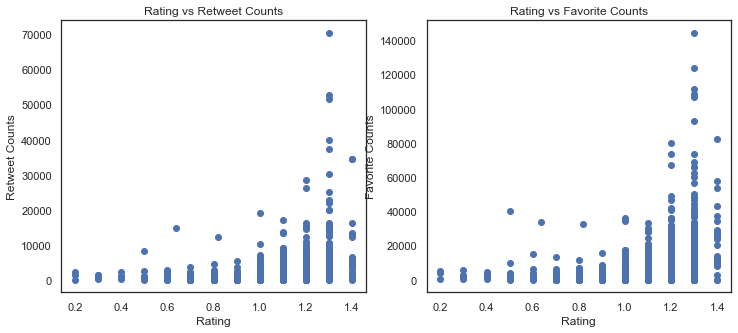

In [947]:
rating_retweet_favorite()

### Q5: How is the retweet counts correlate to favorite counts?

In [948]:
def retweet_vs_favorite():
    df = pd.read_csv(MERGED_FILE)
    
    fig, ax1 = plt.subplots(figsize=FIG_SIZE)
    ax1.scatter(df.retweet_cnt, df.favorite_cnt);
    ax1.set(title="Retweet Counts vs Favorite Counts", 
            xlabel='Retweet Counts',
            ylabel='Favorite Counts')
    
    plt.savefig(os.path.join(IMG_PATH, 'retweet_vs_favorite'))

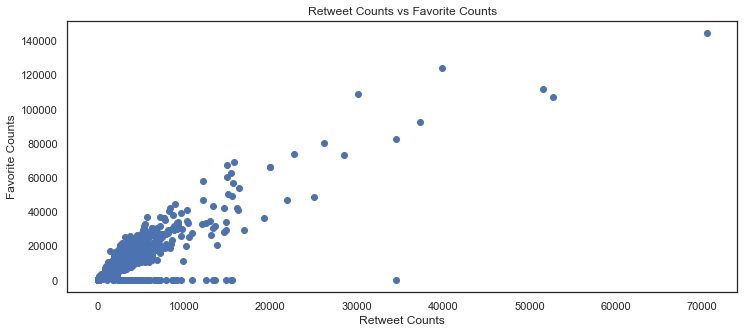

In [949]:
retweet_vs_favorite()

In [928]:
df = pd.read_csv(MERGED_FILE)
df.query('retweet_cnt>35000').sort_values(by='retweet_cnt', ascending=False)

,tweet_id,rating_numerator,rating_denominator,name,rating,breed,conf,outcome,retweet_cnt,favorite_cnt
738,744234799360020481,13,10,no-name,1.3,Labrador_retriever,0.825333,True,70504,144449
766,739238157791694849,13,10,no-name,1.3,Eskimo_dog,0.503372,True,52755,106949
383,807106840509214720,13,10,Stephan,1.3,Chihuahua,0.505370,True,51532,111360
289,822872901745569793,13,10,no-name,1.3,Lakeland_terrier,0.196015,True,39844,123768
54,879415818425184262,13,10,Duddles,1.3,English_springer,0.383404,True,37305,92622


## Analysis Summary

> **The top five most tweeted breeds are:** <br> 1) Golden Retriever<br> 2) Labrador Retriever<br> 3) Pembroke<br> 4) Chihuahue <br> 5) Pug

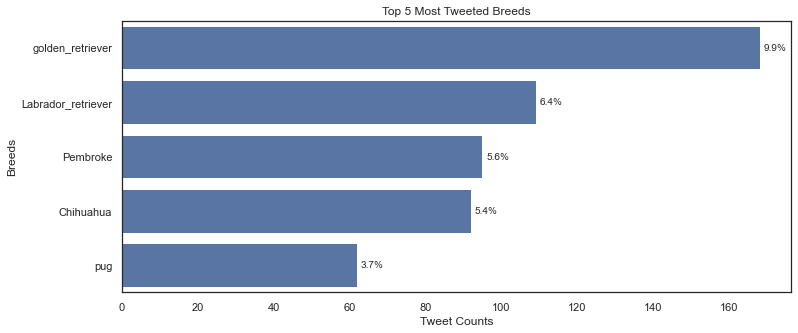

In [929]:
top_tweeted_breed()

> **The top five most retweeted dogs are:** <br> 1) No-name with 70504 retweets <br> 2) No-name with 52755 retweets<br> 3) Stephan with 51532 retweets<br> 4) No-name with 39844 retweets and<br> 5) Duddles with 37305 retweets

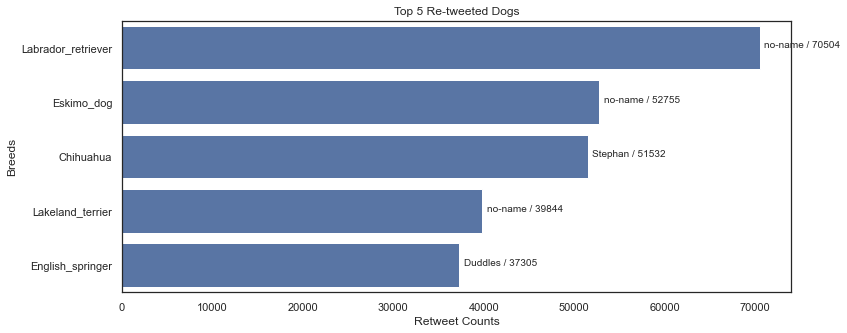

In [930]:
top_retweeted_dogs()

> **The top five most favorite dogs are:** <br> 1) No-name with 144449 favorites <br> 2) No-name with 123768 favorites<br> 3) Stephan 111360 favorites<br> 4) No-name 108617 favorites<br> 5) Duddles 106949 favorites

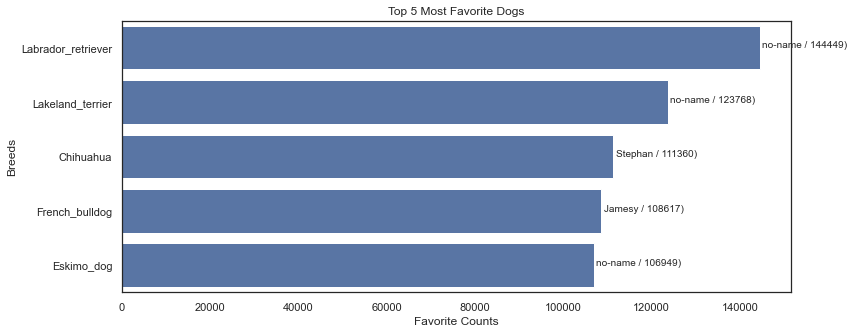

In [931]:
top_favorite_dogs()

> **The top five most retweeted dogs or the top five most favorite dogs are not the highest rated dog**

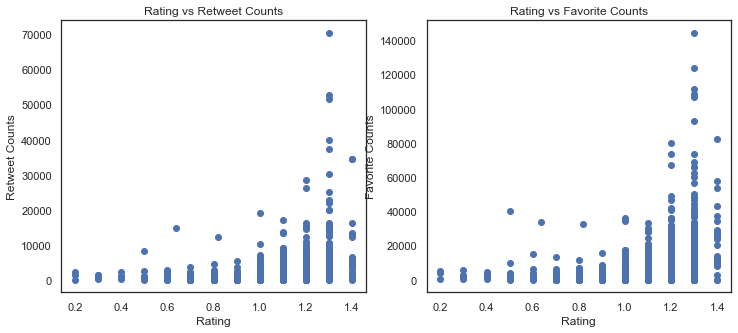

In [932]:
rating_retweet_favorite()

> **There seemed like a strong linear relationship betweet the retweets count and favorite count, but it's not always the case.**

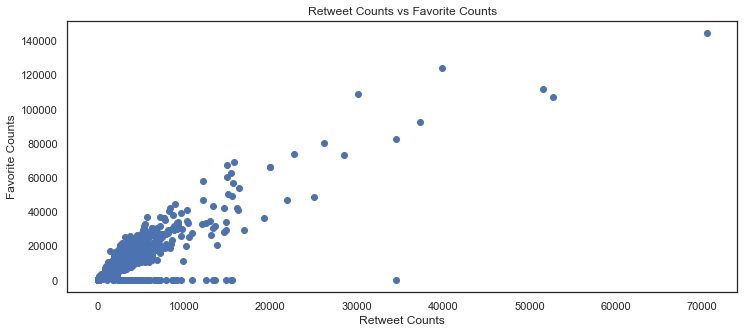

In [933]:
retweet_vs_favorite()